In [52]:
import numpy as np
import pandas as pd 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [53]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser="auto")
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

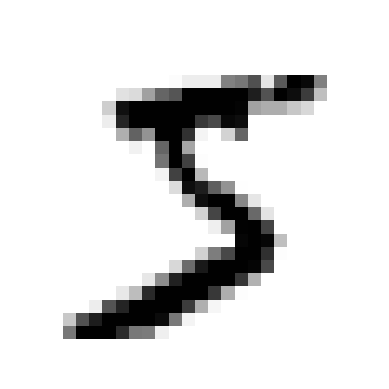

In [54]:
X, y = mnist["data"], mnist["target"]

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()

In [55]:
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [56]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])

array([ True])

In [57]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [58]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [59]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [60]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [61]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [62]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


In [63]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [64]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [65]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

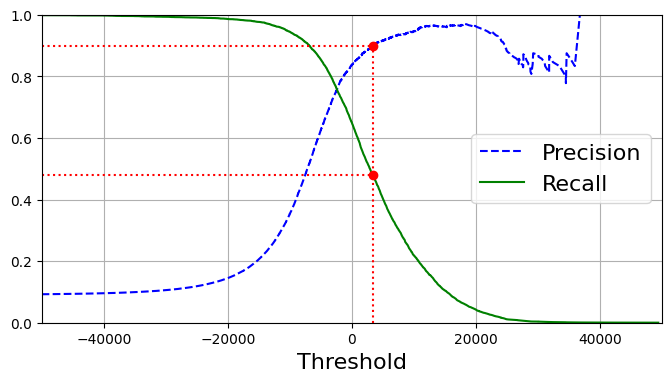

In [78]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                                                                          
plt.show()

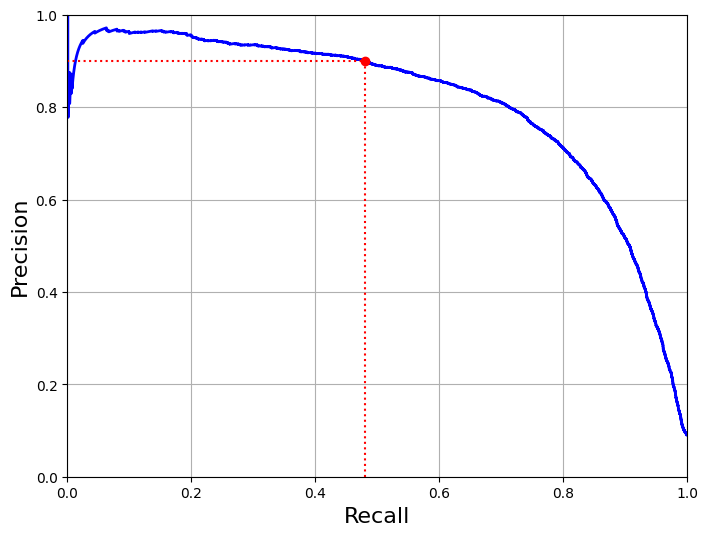

In [76]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [79]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90_precision)

y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))

recall_score(y_train_5, y_train_pred_90)

3370.0194991439557
0.9000345901072293


0.4799852425751706